In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from config import RUN_GATK, QC, DOWNLOAD_REF_GENOME, RESULTS_FOLDER, DATA_FOLDER, NORMAL_R1, NORMAL_R2, TUMOR_R1, TUMOR_R2

In [2]:
# Download reference human genome
if DOWNLOAD_REF_GENOME:
    !wget -O "$DATA_FOLDER/hg38.fa.gz" http://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
    !gunzip "$DATA_FOLDER/hg38.fa.gz"

# Quality control

In [3]:
# Perform quality checks using tools like FastQC and summarize quality metrics (e.g., sequence counts, 
# per-base quality, read duplication levels).

# Decompress if needed
!gunzip "$DATA_FOLDER"/*.fastq.gz

if QC:
    # Run FASTQC
    # The summary of quality metrics is provided in the pdf report
    !fastqc "$DATA_FOLDER/$NORMAL_R1" "$DATA_FOLDER/$NORMAL_R2" "$DATA_FOLDER/$TUMOR_R1" "$DATA_FOLDER/$TUMOR_R2" -o "$RESULTS_FOLDER"
    !multiqc "$RESULTS_FOLDER" -o "$RESULTS_FOLDER/multiqc_report"

zsh:1: no matches found: data/*.fastq.gz
null
null
Started analysis of PA221MH-lib09-P19-Norm_S1_L001_R1_001.fastq
null
null
Approx 5% complete for PA221MH-lib09-P19-Norm_S1_L001_R1_001.fastq
Approx 10% complete for PA221MH-lib09-P19-Norm_S1_L001_R1_001.fastq
Approx 15% complete for PA221MH-lib09-P19-Norm_S1_L001_R1_001.fastq
Approx 20% complete for PA221MH-lib09-P19-Norm_S1_L001_R1_001.fastq
Approx 25% complete for PA221MH-lib09-P19-Norm_S1_L001_R1_001.fastq
Approx 30% complete for PA221MH-lib09-P19-Norm_S1_L001_R1_001.fastq
Approx 35% complete for PA221MH-lib09-P19-Norm_S1_L001_R1_001.fastq
Approx 40% complete for PA221MH-lib09-P19-Norm_S1_L001_R1_001.fastq
Approx 45% complete for PA221MH-lib09-P19-Norm_S1_L001_R1_001.fastq
Approx 50% complete for PA221MH-lib09-P19-Norm_S1_L001_R1_001.fastq
Approx 55% complete for PA221MH-lib09-P19-Norm_S1_L001_R1_001.fastq
Approx 60% complete for PA221MH-lib09-P19-Norm_S1_L001_R1_001.fastq
Approx 65% complete for PA221MH-lib09-P19-Norm_S1_L001_R1_00

# Alignment and mutation calling

In [4]:
# Align the samples to the human genome using tools like Bowtie2 or BWA.
# https://gatk.broadinstitute.org/hc/en-us/articles/360035535912-Data-pre-processing-for-variant-discovery

# Identify somatic mutations present in the cancer sample but absent in the normal tissue.
# https://gatk.broadinstitute.org/hc/en-us/articles/360035894731-Somatic-short-variant-discovery-SNVs-Indels
if RUN_GATK:
    !chmod +x somatic_mutations.sh
    !./somatic_mutations.sh "$DATA_FOLDER/$NORMAL_R1" "$DATA_FOLDER/$NORMAL_R2" "$DATA_FOLDER/$TUMOR_R1" "$DATA_FOLDER/$TUMOR_R2" "$DATA_FOLDER/hg38.fa" "$RESULTS_FOLDER" "$DATA_FOLDER"

In [5]:
!gunzip "$RESULTS_FOLDER/filtered_variants.vcf.gz"

gunzip: can't stat: results/filtered_variants.vcf.gz (results/filtered_variants.vcf.gz.gz): No such file or directory


In [6]:
def vcf_to_dataframe(vcf_file_path):
    # Read a vcf file as a pandas dataframe
    
    # Dictionary to store INFO ID and Description
    info_dict = {}
    
    # Read the file
    with open(vcf_file_path, 'r') as vcf_file:
        lines = []
        for line in vcf_file:
            if line.startswith("##INFO"):
                # Extract the ID and Description using regex
                match = re.search(r'ID=(.*?),.*?Description="(.*?)"', line)
                if match:
                    info_id = match.group(1)
                    description = match.group(2)
                    info_dict[info_id] = description
            elif not line.startswith("##"):  # Skip other metadata lines
                lines.append(line.strip())

    # Extract the column names from the first line and data from the rest
    column_names = lines[0].lstrip("#").split("\t")
    data = [line.split("\t") for line in lines[1:]]
    
    # Create a Pandas DataFrame
    df = pd.DataFrame(data, columns=column_names)
                      
    # Split INFO column into separate columns
    info_df = split_info_column(df["INFO"])
    df = pd.concat([df.drop(columns=["INFO"]), info_df], axis=1)
                      
    # Split FORMAT columns for 'normal' and 'tumor'
    format_fields = df["FORMAT"].iloc[0].split(":")
    for sample in ["normal", "tumor"]:
        sample_data = df[sample].str.split(":", expand=True)
        sample_data.columns = [f"{sample}_{field}" for field in format_fields]
        df = pd.concat([df, sample_data], axis=1)

    # Drop original FORMAT and sample columns
    df = df.drop(columns=["FORMAT", "normal", "tumor"])

    return df, info_dict

# Expand INFO column
def split_info_column(info_series):
    # Expand INFO column into key-value dictionary rows
    info_dicts = info_series.str.split(";", expand=False).apply(
        lambda x: {item.split("=", 1)[0]: item.split("=", 1)[1] if "=" in item else np.nan for item in x}
    )
    # Convert list of dictionaries into a DataFrame
    return pd.DataFrame(info_dicts.tolist())

In [7]:
VCF_FILE = f"{RESULTS_FOLDER}/filtered_variants.vcf"
df, info = vcf_to_dataframe(VCF_FILE)

In [8]:
info

{'AS_FilterStatus': 'Filter status for each allele, as assessed by ApplyVQSR. Note that the VCF filter field will reflect the most lenient/sensitive status across all alleles.',
 'AS_SB_TABLE': 'Allele-specific forward/reverse read counts for strand bias tests. Includes the reference and alleles separated by |.',
 'AS_UNIQ_ALT_READ_COUNT': 'Number of reads with unique start and mate end positions for each alt at a variant site',
 'CONTQ': 'Phred-scaled qualities that alt allele are not due to contamination',
 'DP': 'Approximate read depth; some reads may have been filtered',
 'ECNT': 'Number of potential somatic events in the assembly region',
 'ECNTH': 'Number of somatic events in best supporting haplotype for each alt allele',
 'GERMQ': 'Phred-scaled quality that alt alleles are not germline variants',
 'MBQ': 'median base quality by allele',
 'MFRL': 'median fragment length by allele',
 'MMQ': 'median mapping quality by allele',
 'MPOS': 'median distance from end of read',
 'NALOD':

In [9]:
df.columns

Index(['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'AS_FilterStatus',
       'AS_SB_TABLE', 'DP', 'ECNT', 'ECNTH', 'GERMQ', 'MBQ', 'MFRL', 'MMQ',
       'MPOS', 'NALOD', 'NLOD', 'POPAF', 'TLOD', 'RPA', 'RU', 'STR', 'STRQ',
       'normal_GT', 'normal_AD', 'normal_AF', 'normal_DP', 'normal_F1R2',
       'normal_F2R1', 'normal_FAD', 'normal_PGT', 'normal_PID', 'normal_PS',
       'normal_SB', 'tumor_GT', 'tumor_AD', 'tumor_AF', 'tumor_DP',
       'tumor_F1R2', 'tumor_F2R1', 'tumor_FAD', 'tumor_PGT', 'tumor_PID',
       'tumor_PS', 'tumor_SB'],
      dtype='object')

<AxesSubplot:>

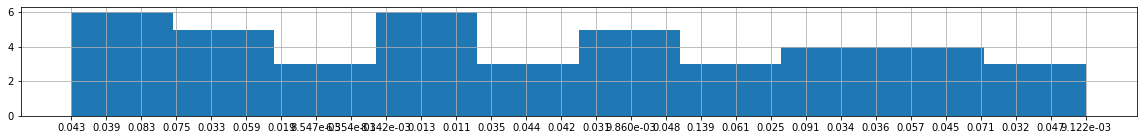

In [10]:
df["normal_AF"].hist(figsize=(20,2))

In [11]:
df[df["normal_AF"].isna()]

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,AS_FilterStatus,AS_SB_TABLE,DP,...,tumor_AD,tumor_AF,tumor_DP,tumor_F1R2,tumor_F2R1,tumor_FAD,tumor_PGT,tumor_PID,tumor_PS,tumor_SB


In [12]:
# Use the normal tissue to calculate the median background mutation level.
# The background mutation levels accounts for sequencing errors or biases
# that can mimic true mutations.
df['normal_AF'] = df['normal_AF'].astype(float)
df['tumor_AF'] = df['tumor_AF'].astype(float)
normal_af = df["normal_AF"].median()
normal_af

0.039

In [13]:
# Determine how many reads per million are required to confidently call a given mutation.
normal_rpm = normal_af * 1_000_000
normal_rpm

39000.0

In [14]:
filtered_tumor_variants = df[df['tumor_AF'] > normal_af]
filtered_tumor_variants.to_csv(f'{RESULTS_FOLDER}/filtered_tumor_variants.csv')
filtered_tumor_variants

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,AS_FilterStatus,AS_SB_TABLE,DP,...,tumor_AD,tumor_AF,tumor_DP,tumor_F1R2,tumor_F2R1,tumor_FAD,tumor_PGT,tumor_PID,tumor_PS,tumor_SB
0,chr1,26773694,.,G,C,.,clustered_events;haplotype;normal_artifact,SITE,"104,453|1,21",581,...,"276,12",0.050,288,"97,8","137,3","245,12",0|1,26773694_G_C,26773694,"45,231,1,11"
1,chr1,26773703,.,G,A,.,clustered_events;haplotype;normal_artifact,SITE,"131,481|1,21",634,...,"299,12",0.047,311,"115,9","146,2","264,12",0|1,26773694_G_C,26773694,"57,242,1,11"
2,chr1,26773706,.,G,C,.,clustered_events;haplotype;normal_artifact,SITE,"133,481|1,21",644,...,"299,12",0.047,311,"114,9","147,3","264,12",0|1,26773694_G_C,26773694,"57,242,1,11"
3,chr10,35633286,.,C,A,.,clustered_events;haplotype,SITE,"14,18|1,1",34,...,"14,2",0.182,16,"2,1","6,0","8,1",0|1,35633286_C_A,35633286,"6,8,1,1"
4,chr10,35633295,.,A,T,.,clustered_events;haplotype,SITE,"13,19|1,1",34,...,"15,2",0.167,17,"3,0","6,0","9,1",0|1,35633286_C_A,35633286,"6,9,1,1"
5,chr10,35633300,.,C,G,.,clustered_events;haplotype,SITE,"14,21|1,1",37,...,"18,2",0.143,20,"4,1","7,0","11,1",0|1,35633286_C_A,35633286,"7,11,1,1"
6,chr10,35633313,.,A,G,.,clustered_events,SITE,"15,25|2,2",46,...,"22,4",0.168,26,"8,1","6,1","14,2","8,14,2,2",None,None,None
7,chr10,87864482,.,A,G,.,normal_artifact,SITE,"85,87|2,2",182,...,"77,2",0.042,79,"21,0","23,1","44,1","38,39,1,1",None,None,None
8,chr10,87952098,.,CT,C,.,normal_artifact;slippage;weak_evidence,weak_evidence,"78,94|7,6",188,...,"82,7",0.116,89,"16,3","32,3","49,6","38,44,4,3",None,None,None
9,chr11,64809910,.,G,A,.,clustered_events;haplotype;normal_artifact,SITE,"143,30|1,4",205,...,"70,4",0.054,74,"38,2","27,0","65,3",0|1,64809910_G_A,64809910,"57,13,1,3"


In [15]:
df['ID'].unique()

array(['.'], dtype=object)